In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from time import gmtime, strftime

# Data Generation
np.random.seed(1024)

RLS_A_row = 200
RLS_A_col = 10
RLS_lambda = 50

RLS_A = np.random.normal(0, 1, (RLS_A_row, RLS_A_col))
RLS_x_star = np.random.normal(0,1, RLS_A_col)
RLS_y0 = RLS_A @ RLS_x_star + np.random.normal(0, .01, RLS_A_row)


# Experiment Parameter
exp1_no_clients = 20

exp1_m = [int(RLS_A_row/ exp1_no_clients)] * exp1_no_clients 

exp1_M = []
exp1_M_client = []
exp1_z = []
exp1_z_client = []

exp1_A_client = []
exp1_B_client = []
exp1_C_client = []
exp1_lipschitz_client = []
exp1_l_cocoercive_function = []

fn_idx = 0
for client_idx in range(exp1_no_clients):
    M = []
    z = []
    
    A_client_m = []
    B_client_m = []
    C_client_m = []
    
    for _ in range(exp1_m[client_idx]):
        A = 2 * np.transpose(RLS_A) @ np.outer(np.eye(RLS_A_row)[fn_idx], np.eye(RLS_A_row)[fn_idx]) @ RLS_A
        A_client_m.append(A)
        
        B = -2 * np.transpose(RLS_A) @ np.outer(np.eye(RLS_A_row)[fn_idx], np.eye(RLS_A_row)[fn_idx])
        B_client_m.append(B)
        
        C = 2 * (RLS_lambda - 1) * np.outer(np.eye(RLS_A_row)[fn_idx], np.eye(RLS_A_row)[fn_idx])
        C_client_m.append(C)
        
        M.append(np.block([[A, B], [-np.transpose(B), C]]))
        exp1_eval_function = np.linalg.eig(M[-1])[0]
        exp1_l_cocoercive_function.append(1/np.min(np.real(1/ exp1_eval_function[np.abs(exp1_eval_function) > 1e-5])))
        z.append(np.concatenate((np.zeros(RLS_A_col), -2 * RLS_lambda * np.outer(np.eye(RLS_A_row)[fn_idx], np.eye(RLS_A_row)[fn_idx]) @ RLS_y0)))
        fn_idx = fn_idx + 1
    
    exp1_M_client.append(np.mean(M, axis = 0))
    exp1_lipschitz_client.append(np.sqrt(max(np.real(np.linalg.eig(np.mean(M, axis = 0).T @ np.mean(M, axis = 0))[0]))))
    exp1_z_client.append(np.mean(z, axis = 0))
    
    exp1_M.append(M)
    exp1_z.append(z)
    
exp1_M_mean = np.mean(exp1_M_client, axis = 0)
exp1_z_mean = np.mean(exp1_z_client, axis = 0)

exp1_lipschitz = np.sqrt(np.max(np.real(np.linalg.eig(exp1_M_mean.T @ exp1_M_mean)[0])))
exp1_mu_total = min(np.min(np.linalg.eig(np.transpose(RLS_A) @ RLS_A)[0]), RLS_lambda - 1)/RLS_A_row 
exp1_x_optimal = -np.linalg.inv(exp1_M_mean) @ exp1_z_mean

#### Compute the cocoercivity parameter
exp1_Jacobian = (2/RLS_A_row)*np.block([[np.transpose(RLS_A)@RLS_A, -np.transpose(RLS_A)],[RLS_A, (RLS_lambda - 1)*np.eye(RLS_A_row)]])
exp1_l_cocoercive = 1/np.min(np.real(1/np.linalg.eig(exp1_Jacobian)[0]))
# exp1_l_cocoercive_stoch = np.max(exp1_l_cocoercive_function)    #/exp1_no_clients
exp1_lipschitz_total = np.sqrt(np.max(np.real(np.linalg.eig(exp1_Jacobian)[0])))


#### Gradient Operator for RLS

def exp1_operator(x, client_idx = None, m_idx = None):
    if client_idx == None and m_idx == None:
        return exp1_M_mean @ x + exp1_z_mean
    elif m_idx == None:
        return exp1_M_client[client_idx] @ x + exp1_z_client[client_idx]
    else:
        return exp1_M[client_idx][m_idx] @ x + exp1_z[client_idx][m_idx]


In [2]:
def ProxSkip_VIP_FL(x_initial, x_optimal, no_client, m, gamma, prob, operator, communication_round = 1000):
    ### no_clients = the number of nodes
    ### m = list of size no_clients containing the number of functions available to each client 
    ### gamma = step-size
    ### prob = probability of a communication step
    
    x = x_initial
    dim = len(x_initial)
    initial_error = np.sum((x - x_optimal)**2)
    error = [1]
    
    control_variate_client = np.zeros((no_client, dim))
    x_client = np.ones((no_client, 1)) * x
    x_hat_client = np.zeros((no_client, dim))
    x_dash_client = np.zeros((no_client, dim))
    
    rounds = 0
    while rounds < (communication_round - 1):
        theta = np.random.binomial(1, p = prob)
        
        if theta == 1:
            rounds += 1
            for client_idx in range(no_client):
                g_client = operator(x_client[client_idx], client_idx)/ no_client      ### Gradients scaled by number of nodes
                x_hat_client[client_idx] = x_client[client_idx] - gamma * (g_client - control_variate_client[client_idx]) 
                x_dash_client[client_idx] = x_hat_client[client_idx] - (gamma/ prob) * control_variate_client[client_idx]
            x = np.mean(x_dash_client, axis= 0)
            x_client = np.ones((no_client, 1)) * x
            error.append(np.sum((x - x_optimal)**2)/ initial_error)
            for client_idx in range(no_client):
                control_variate_client[client_idx] = control_variate_client[client_idx] + (prob/ gamma) * (x_client[client_idx] - x_hat_client[client_idx])
        else:
            for client_idx in range(no_client):
                g_client = operator(x_client[client_idx], client_idx)/ no_client
                x_client[client_idx] = x_client[client_idx] - gamma * (g_client - control_variate_client[client_idx])
    return error






def local_GDA(x_initial, x_optimal, no_client, m, L, mu, operator, sync_gap, communication_round = 1000):
    ### no_clients = the number of nodes
    ### m = list of size no_clients containing the number of functions available to each client 
    
    x = x_initial
    initial_error = np.sum((x - x_optimal)**2)
    error = []
    kappa = L/mu
    a = 2048*sync_gap*(kappa**2)
    
    x_client = np.ones((no_client, 1)) * x
    
    total_iteration = 0
    for rounds in range(communication_round):
        x = np.mean(x_client, axis= 0)
        error.append(np.sum((x - x_optimal)**2)/ initial_error)
        for client_idx in range(no_client):
            x_client[client_idx] = x
            for iteration in range(sync_gap):
                total_iteration += 1
                gamma = 8/(mu * (total_iteration + a))
                x_client[client_idx] = x_client[client_idx] - gamma * operator(x_client[client_idx], client_idx)
    return error






def local_EG(x_initial, x_optimal, no_client, m, gamma1, gamma2, operator, sync_gap, communication_round = 1000):
    ### no_clients = the number of nodes
    ### m = list of size no_clients containing the number of functions available to each client 
    
    x = x_initial
    initial_error = np.sum((x - x_optimal)**2)
    error = []
    
    x_client = np.ones((no_client, 1)) * x
    
    for rounds in range(communication_round):
        x = np.mean(x_client, axis= 0)
        error.append(np.sum((x - x_optimal)**2)/ initial_error)
        for client_idx in range(no_client):
            x_client[client_idx] = x
            for iteration in range(sync_gap):
                x_client_mid = x_client[client_idx] - gamma1 * operator(x_client[client_idx], client_idx)
                x_client[client_idx] = x_client[client_idx] - gamma2 * operator(x_client_mid, client_idx)
    return error

In [3]:
# Experiment Parameter
exp1_communication_round = 400
exp1_sync_gap = int(exp1_communication_round/ exp1_no_clients)

ProxSkip_error = ProxSkip_VIP_FL(np.zeros(RLS_A_col + RLS_A_row), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(2 * exp1_l_cocoercive), np.sqrt(exp1_mu_total/(2 * exp1_l_cocoercive)), exp1_operator, communication_round= exp1_communication_round)
local_GDA_error = local_GDA(np.zeros(RLS_A_col + RLS_A_row), exp1_x_optimal, exp1_no_clients, exp1_m, exp1_lipschitz, exp1_mu_total, exp1_operator, exp1_sync_gap, communication_round= exp1_communication_round)
local_EG_error = local_EG(np.zeros(RLS_A_col + RLS_A_row), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(21 * exp1_sync_gap * np.max(exp1_lipschitz_client)), 1/(21 * exp1_sync_gap * np.max(exp1_lipschitz_client)), exp1_operator, exp1_sync_gap, communication_round= exp1_communication_round)

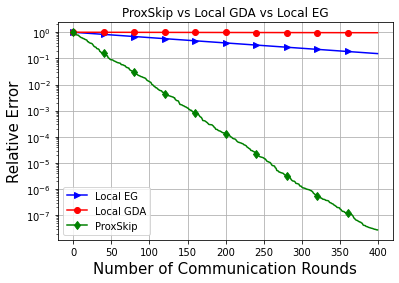

In [4]:
fig = plt.figure()
markers_on = np.arange(0, exp1_communication_round, exp1_communication_round/10).astype(int).tolist()

plt.plot(np.arange(exp1_communication_round), local_EG_error,'-b>', markevery = markers_on, label = 'Local EG')
plt.plot(np.arange(exp1_communication_round), local_GDA_error,'-ro', markevery = markers_on, label = 'Local GDA')
plt.plot(np.arange(exp1_communication_round), ProxSkip_error, '-gd', markevery = markers_on, label = 'ProxSkip')


plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error", fontsize = 15)
plt.xlabel("Number of Communication Rounds", fontsize = 15)
plt.legend(fontsize = 10)
plt.title("ProxSkip vs Local GDA vs Local EG")
plt.savefig('Plots/RLSxDataset1_' + strftime("%Y%m%d-%H%M%S") + '.pdf', format='pdf', bbox_inches='tight')

In [5]:
def SProxSkip_VIP_FL(x_initial, x_optimal, no_client, m, gamma, prob, operator, communication_round = 1000, trials = 10):
    ### no_clients = the number of nodes
    ### m = list of size no_clients containing the number of functions available to each client 
    ### gamma = step-size
    ### prob = probability of a communication step
    
    relative_error = []
    
    for _ in range(trials):
        x = x_initial
        dim = len(x_initial)
        initial_error = np.sum((x - x_optimal)**2)
        error = [1]
    
        control_variate_client = np.zeros((no_client, dim))
        x_client = np.ones((no_client, 1)) * x
        x_hat_client = np.zeros((no_client, dim))
        x_dash_client = np.zeros((no_client, dim))
    
        rounds = 0
        while rounds < (communication_round - 1):
            theta = np.random.binomial(1, p = prob)
        
            if theta == 1:
                rounds += 1
                for client_idx in range(no_client):
                    m_idx = np.random.choice(m[client_idx], 1)[0]
                    g_client = operator(x_client[client_idx], client_idx, m_idx)/ no_client
                    x_hat_client[client_idx] = x_client[client_idx] - gamma * (g_client - control_variate_client[client_idx]) 
                    x_dash_client[client_idx] = x_hat_client[client_idx] - (gamma/ prob) * control_variate_client[client_idx]
                x = np.mean(x_dash_client, axis= 0)
                x_client = np.ones((no_client, 1)) * x
                error.append(np.sum((x - x_optimal)**2)/ initial_error)
                for client_idx in range(no_client):
                    control_variate_client[client_idx] = control_variate_client[client_idx] + (prob/ gamma) * (x_client[client_idx] - x_hat_client[client_idx])
            else:
                for client_idx in range(no_client):
                    m_idx = np.random.choice(m[client_idx], 1)[0]
                    g_client = operator(x_client[client_idx], client_idx, m_idx)/ no_client
                    x_client[client_idx] = x_client[client_idx] - gamma * (g_client - control_variate_client[client_idx])
        relative_error.append(error)
    return relative_error


def ProxSkip_L_SVRGDA_FL(x_initial, x_optimal, no_client, m, gamma, comm_prob, estimator_prob, operator, communication_round = 1000, trials = 10):
    relative_error = []
    
    for _ in range(trials):
        x = x_initial 
        dim = len(x)
        initial_error = np.sum((x - x_optimal)**2)
        error = [1]
    
        control_variate_client = np.zeros((no_client, dim))
        x_client = np.ones((no_client, 1)) * x
        w_client = x_client
        x_hat_client = np.zeros((no_client, dim))
        x_dash_client = np.zeros((no_client, dim))
    
        rounds = 0
    
        while rounds < (communication_round - 1):
            theta = np.random.binomial(1, p = comm_prob)
            eta = np.random.binomial(1, p = estimator_prob)
        
            if theta == 1:
                rounds += 1
                for client_idx in range(no_client):
                    m_idx = np.random.choice(m[client_idx], 1)[0]
                    g_client = (operator(x_client[client_idx], client_idx, m_idx) - operator(w_client[client_idx], client_idx, m_idx) + operator(w_client[client_idx], client_idx))/no_client
                    if eta == 1:
                        w_client[client_idx] = x_client[client_idx]
                    x_hat_client[client_idx] = x_client[client_idx] - gamma * (g_client - control_variate_client[client_idx])
                    x_dash_client[client_idx] = x_hat_client[client_idx] - (gamma/ comm_prob) * control_variate_client[client_idx]
                x = np.mean(x_dash_client, axis = 0)
                x_client = np.ones((no_client, 1)) * x
                error.append(np.sum((x - x_optimal)**2)/ initial_error)
                
                for client_idx in range(no_client):
                    control_variate_client[client_idx] = control_variate_client[client_idx] + (comm_prob/ gamma) * (x_client[client_idx] - x_hat_client[client_idx])
            else:
                for client_idx in range(no_client):
                    m_idx = np.random.choice(m[client_idx], 1)[0]
                    g_client = (operator(x_client[client_idx], client_idx, m_idx) - operator(w_client[client_idx], client_idx, m_idx) + operator(w_client[client_idx], client_idx))/no_client
                    if eta == 1:
                        w_client[client_idx] = x_client[client_idx]
                    x_client[client_idx] = x_client[client_idx] - gamma * (g_client - control_variate_client[client_idx])
        relative_error.append(error)
    return relative_error



def local_SGDA(x_initial, x_optimal, no_client, m, L, mu, operator, sync_gap, communication_round = 1000, trials = 10):
    ### no_clients = the number of nodes
    ### m = list of size no_clients containing the number of functions available to each client 
    
    relative_error = []
    for _ in range(trials):
        x = x_initial
        initial_error = np.sum((x - x_optimal)**2)
        error = []
        kappa = L/mu
        a = 2048*sync_gap*(kappa**2)
    
        x_client = np.ones((no_client, 1)) * x
    
        total_iteration = 0
        for rounds in range(communication_round):
            x = np.mean(x_client, axis= 0)
            error.append(np.sum((x - x_optimal)**2)/ initial_error)
            for client_idx in range(no_client):
                x_client[client_idx] = x
                for iteration in range(sync_gap):
                    total_iteration += 1
                    gamma = 8/(mu * (total_iteration + a))
                    m_idx = np.random.choice(m[client_idx], 1)[0]
                    x_client[client_idx] = x_client[client_idx] - gamma * operator(x_client[client_idx], client_idx, m_idx)
        relative_error.append(error)
    return relative_error






def local_SEG(x_initial, x_optimal, no_client, m, gamma1, gamma2, operator, sync_gap, communication_round = 1000, trials = 10):
    ### no_clients = the number of nodes
    ### m = list of size no_clients containing the number of functions available to each client 
    relative_error = []
    for _ in range(trials):
        x = x_initial
        initial_error = np.sum((x - x_optimal)**2)
        error = []
        
        x_client = np.ones((no_client, 1)) * x
        for rounds in range(communication_round):
            x = np.mean(x_client, axis= 0)
            error.append(np.sum((x - x_optimal)**2)/ initial_error)
            for client_idx in range(no_client):
                x_client[client_idx] = x
                for iteration in range(sync_gap):
                    m1_idx, m2_idx = np.random.choice(m[client_idx], 2)
                    x_client_mid = x_client[client_idx] - gamma1 * operator(x_client[client_idx], client_idx, m1_idx)
                    x_client[client_idx] = x_client[client_idx] - gamma2 * operator(x_client_mid, client_idx, m2_idx)
        relative_error.append(error)
    return relative_error



In [6]:
# Experiment Parameter
exp1_communication_round = 400
exp1_sync_gap = int(exp1_communication_round/ exp1_no_clients)

SProxSkip_error = SProxSkip_VIP_FL(np.zeros(RLS_A_col + RLS_A_row), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(2 * np.max(exp1_l_cocoercive_function)), np.sqrt(exp1_mu_total/(2 * np.max(exp1_l_cocoercive_function))), exp1_operator, communication_round= exp1_communication_round)
local_SGDA_error = local_SGDA(np.zeros(RLS_A_col + RLS_A_row), exp1_x_optimal, exp1_no_clients, exp1_m, np.max(exp1_lipschitz_client),exp1_mu_total, exp1_operator, int(exp1_communication_round/ exp1_no_clients), communication_round= exp1_communication_round)
ProxSkip_L_SVRGDA_FL_error = ProxSkip_L_SVRGDA_FL(np.zeros(RLS_A_col + RLS_A_row), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(6 * np.max(exp1_l_cocoercive_function)) , np.sqrt(exp1_mu_total/(6 * np.max(exp1_l_cocoercive_function))), 2 * (exp1_mu_total/ (6 * np.max(exp1_l_cocoercive_function))), exp1_operator, communication_round= exp1_communication_round)
exp1_sync_gap = int(exp1_communication_round/ exp1_no_clients)
local_SEG_error1 = local_SEG(np.zeros(RLS_A_col + RLS_A_row), exp1_x_optimal, exp1_no_clients, exp1_m, 1/(21 * exp1_sync_gap * np.max(exp1_lipschitz_client)), 1/(21 * exp1_sync_gap * np.max(exp1_lipschitz_client)), exp1_operator, exp1_sync_gap, communication_round= exp1_communication_round)

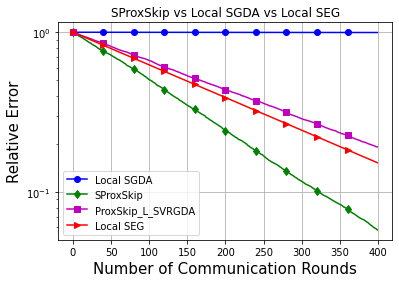

In [8]:
fig = plt.figure()
markers_on = np.arange(0, exp1_communication_round, exp1_communication_round/10).astype(int).tolist()

plt.plot(np.arange(exp1_communication_round), np.mean(local_SGDA_error, axis = 0),'-bo', markevery = markers_on, label = 'Local SGDA')
plt.plot(np.arange(exp1_communication_round), np.mean(SProxSkip_error, axis = 0), '-gd', markevery = markers_on, label = 'SProxSkip')
plt.plot(np.arange(exp1_communication_round), np.mean(ProxSkip_L_SVRGDA_FL_error, axis = 0), '-ms', markevery = markers_on, label= "ProxSkip_L_SVRGDA")


plt.plot(np.arange(exp1_communication_round), np.mean(local_SEG_error1, axis = 0),'-r>', markevery = markers_on, label = 'Local SEG')

plt.yscale('log')
plt.grid(True)
plt.ylabel("Relative Error", fontsize = 15)
plt.xlabel("Number of Communication Rounds", fontsize = 15)
plt.legend(fontsize = 10)
plt.title("SProxSkip vs Local SGDA vs Local SEG")
plt.savefig('Plots/RLSxDataset1_Stochastic' + strftime("%Y%m%d-%H%M%S") + '.pdf', format='pdf', bbox_inches='tight')